In [1]:
import numpy as np
import torch
import torchvision
import glob as gb
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import tqdm
import os
import re
import sys
import torch
import scipy.io
import scipy.signal
import mat73
import imageio
import lpips
import random
import torchvision
import math
# import random
# import time
import skimage._shared.utils
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.nn as nn
import torch.fft as fft
import torch.nn.functional as F
import cv2 as cv
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.utils import save_image
# from PIL import Image
# from skimage import color, data, restoration, img_as_float
from tqdm import tqdm
#import unet
#from unet import UNet
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import uft
from pypfm import PFMLoader
loader = PFMLoader(color=False, compress=False)
#%matplotlib inline



def get_paths(path):
    paths = []
    for name in gb.glob(path+'*'):
        paths.append(name)
    return paths

import numpy as np

target_psnr=40

def add_gaussian_noise(image, target_psnr):
    max_value = np.max(image)
    mse = max_value**2 / (10**(target_psnr / 10))
    std_dev = np.sqrt(mse)
    
    noise = np.random.randn(*image.shape) * std_dev
    noisy_image = image + noise
    
    return noisy_image


import cv2
import numpy as np

def add_noise_to_image(image, target_PSNR_dB):
    max_pixel_value = 1.0  # Assuming image pixel values are in the range [0, 1]
    target_MSE = (max_pixel_value ** 2) / (10 ** (target_PSNR_dB / 10))
    
    noise = torch.randn_like(image)  # Generate Gaussian noise with the same shape as the image
    noisy_image = image + noise
    
    noisy_MSE = F.mse_loss(noisy_image, image)
    
    noise_factor = torch.sqrt(target_MSE / noisy_MSE)
    noisy_image = image + noise_factor * noise
    
    return noisy_image


def center_crop(tensor, output_size):
    # Get the original shape of the tensor
    original_shape = tensor.size()

    # Calculate the starting indices for the crop
    start_h = math.floor((original_shape[-2] - output_size[-2]) / 2)
    start_w = math.floor((original_shape[-1] - output_size[-1]) / 2)

    # Calculate the ending indices for the crop
    end_h = start_h + output_size[-2]
    end_w = start_w + output_size[-1]

    # Perform the center crop
    cropped_tensor = tensor[:, :, start_h:end_h, start_w:end_w]

    return cropped_tensor

def pad_image_dimensions(image, desired_shape):
    """
    Pads the last two dimensions of the given image to the desired shape.
    
    Args:
        image (numpy.ndarray): Input image represented as a 4D numpy array.
        desired_shape (tuple): Desired shape of the padded image in the format (height, width).
        
    Returns:
        numpy.ndarray: Padded image as a 4D numpy array.
    """
    current_shape = image.shape
    padding_height = desired_shape[0] - current_shape[-2]
    padding_width = desired_shape[1] - current_shape[-1]
    
    # Calculate the amount of padding required on each side
    top_padding = padding_height // 2
    bottom_padding = padding_height - top_padding
    left_padding = padding_width // 2
    right_padding = padding_width - left_padding
    
    # Pad the last two dimensions of the image
    padded_image = np.pad(image, ((0, 0), (0, 0), (top_padding, bottom_padding), (left_padding, right_padding)), mode='constant')
    
    return padded_image

def PSNR(gt, recon):
    mse = np.mean((gt - recon) ** 2)
    if(mse == 0): 
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr


def crop_image(original_array):

    # Calculate the crop coordinates
    original_height, original_width = original_array.shape[:2]
    crop_size = 540

    left = (original_width - crop_size) // 2
    top = (original_height - crop_size) // 2
    right = (original_width + crop_size) // 2
    bottom = (original_height + crop_size) // 2

    # Perform the center crop
    cropped_img = original_array[top:bottom, left:right]
    return cropped_img

def get_psfs(fname): 
    psf=np.zeros((12,3,1518,2012))
    psf_depths=np.array([2,3,4,5,6,7,10,13,16,19,20,22])
    for i in range(len(psf_depths)):
        single_psf = Image.open(fname+'psf_'+str(psf_depths[i])+'.png')
        #single_psf= single_psf.resize((500,500))
        single_psf=np.transpose(single_psf,(2,0,1))
        psf[i,:,:,:]=single_psf
    #psf=pad_image_dimensions(psf,(1520, 2016))
    psf=np.transpose(psf,(2,3,1,0))
    #for k in range(3):
    psf=psf[:,:,:,:][::2,::2]
    psf=np.transpose(psf,(2,3,0,1))
    #psf=np.transpose(psf,(1,0,2,3))
    
    return psf
def load_pfm(file_path):
    """
    load image in PFM type.
    Args:
        file_path string: file path(absolute)
    Returns:
        data (numpy.array): data of image in (Height, Width[, 3]) layout
        scale (float): scale of image
    """
    with open(file_path, encoding="ISO-8859-1") as fp:
        color = None
        width = None
        height = None
        scale = None
        endian = None

        # load file header and grab channels, if is 'PF' 3 channels else 1 channel(gray scale)
        header = fp.readline().rstrip()
        if header == 'PF':
            color = True
        elif header == 'Pf':
            color = False
        else:
            raise Exception('Not a PFM file.')

        # grab image dimensions
        dim_match = re.match(r'^(\d+)\s(\d+)\s$', fp.readline())
        if dim_match:
            width, height = map(int, dim_match.groups())
        else:
            raise Exception('Malformed PFM header.')

        # grab image scale
        scale = float(fp.readline().rstrip())
        if scale < 0:  # little-endian
            endian = '<'
            scale = -scale
        else:
            endian = '>'  # big-endian

        # grab image data
        data = np.fromfile(fp, endian + 'f')
        shape = (height, width, 3) if color else (height, width)

        # reshape data to [Height, Width, Channels]
        data = np.reshape(data, shape)
        data = np.flipud(data)

        return data
def read_pfm(file_path):
    with open(str(file_path), 'rb') as f:
        # Read the header
        header = f.readline().decode().rstrip()
        if header == 'PF':
            color = True
        elif header == 'Pf':
            color = False
        else:
            raise Exception('Not a valid PFM file.')

        # Read width, height, and scale
        width, height = map(int, f.readline().decode().rstrip().split())
        scale = float(f.readline().decode().rstrip())

        # Read the data
        data = np.fromfile(f, '<f' if color else '<f')

    if color:
        # For color images, reshape the data
        data = data.reshape((height, width, 3))
    else:
        # For grayscale images, reshape the data
        data = data.reshape((height, width))

    # Reverse the row order since PFM stores rows in reverse
    data = np.flipud(data)
    return data, scale

def fft_conv2d(input, kernel, bias=None):
    """

    :param input: shape (B, Cin, D, H, W)
    :param kernel: shape (B, Cin, D, H, W)
    :return: shape (B,Cin,D,H,W)
    """
    print(input.max(),kernel.max())
    # input = torch.rfft(input, 2, onesided=False)
    input = torch.fft.fft2(input)
    kernel = torch.fft.fft2(torch.fft.fftshift(kernel,dim=(-2,-1)))

    ###################################### Varun's Implementation ############################

    # # Compute the multiplication
    # # (a+bj)*(c+dj) = (ac-bd)+(ad+bc)j

    # real = input[..., 0] * kernel[..., 0] - input[..., 1] * kernel[..., 1]
    # im = input[..., 0] * kernel[..., 1] + input[..., 1] * kernel[..., 0]
    # # Stack both channels and sum-reduce the input channels dimension
    # outf = torch.stack([real, im], -1)

    ##########################################################################################

    ##################Complex multiplication with custom grad fxn#############################

    outf = input*kernel

    ##########################################################################################

    output = torch.fft.ifft2(outf).real
    return output

def get_meas(psf,image,depth):

    image=np.array(image)
    image=np.transpose(image,(1,2,0))
    psf_depths=np.array([2,3,4,5,6,7,10,13,16,19,20,22])
    #psf_depths=np.array([3.6,  3.7,  3.8 ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,8. ,10,12])
    
    bin_ = depth.min() + (depth.max() - depth.min())*(psf_depths-2.0)/(22.0-2.0)
   
    #print(bin_)
    #print(bin_.max(),bin_.min())
    #print(depth.min(),depth.max())
    new_depth = np.clip(np.digitize(depth,bin_,right=False),1,12)
    print(new_depth)

    final_padded_img=np.zeros((12,3,759,1006))
    
    crop_size=540
    pad_width = (1006) - crop_size
    pad_height = (759) - crop_size

    j=0
    x=np.zeros((3,759,1006))
    #print((np.unique(new_depth)).shape)
    for i in np.unique(new_depth):
        img1=image.copy()
        img1[np.where(new_depth != i)]=0
        padded_img = np.pad(img1, ((pad_height // 2, pad_height - pad_height // 2), (pad_width // 2, pad_width - pad_width // 2), (0, 0)), mode='constant')
        captured_image=padded_img
        padded_img=np.transpose(padded_img,(2,0,1))
        x+=padded_img
        plt.imshow(((captured_image-captured_image.min()/captured_image.max()-captured_image.min())*255).astype(np.uint8))
        plt.show()
        final_padded_img[i-1,:,:,:]=padded_img
        j=j+1
    final_padded_img=np.transpose(final_padded_img,(1,0,2,3))
    captured_image=x.transpose(1,2,0)
    plt.imshow(((captured_image-captured_image.min()/captured_image.max()-captured_image.min())*255).astype(np.uint8))
    plt.show()

    final_padded_img=np.expand_dims(final_padded_img,0)
    psf=np.expand_dims(psf,0)
    final_padded_img=torch.from_numpy(final_padded_img)
    #psf=psf[:,:,:,-12:][::2,::2]
    psf=torch.from_numpy(psf)
    result=fft_conv2d(final_padded_img,psf)
    result=result.squeeze(0)
    result=np.transpose(result,(1,0,2,3))
    res=np.array(result)
    captured_image=np.zeros((3,759,1006))

    for i in range(res.shape[0]):
        captured_image+=res[i,:,:,:]
    captured_image=np.transpose(captured_image,(1,2,0))

    return captured_image



class TrainDataset(Dataset):

    def __init__(self,psf_path,dataset_path):
        self.psfs = get_psfs(psf_path)
        self.image_paths = get_paths(dataset_path+'image_clean/left/')
        self.depth_paths = get_paths(dataset_path+'disparity/left/')
        self.num_im = len(self.image_paths)
        self.totensor = torchvision.transforms.ToTensor()
        #self.transform1=torchvision.transforms.Resize((1000,1000))
        self.transform = torchvision.transforms.CenterCrop(540)


    def __len__(self):
        return len(self.image_paths)
    
    
    def __getitem__(self, index):

      with torch.no_grad():  
        im_path = sorted(self.image_paths)[index]
        depth_path = sorted(self.depth_paths)[index]
       
        im = Image.open(im_path)
        im=self.transform(self.totensor(im))
        captured_image=np.array(np.transpose(im,(1,2,0)))
        plt.imshow(((captured_image-captured_image.min()/captured_image.max()-captured_image.min())*255).astype(np.uint8))
        plt.show()



        #depth_data=load_pfm(depth_path)
        #depth_data=1/np.abs(depth_data)
        #captured_image=depth_data
        #plt.imshow(((captured_image-captured_image.min()/captured_image.max()-captured_image.min())*255).astype(np.uint8),cmap='jet')
        #plt.show()

              
        depth_data=np.flip((-1/loader.load_pfm(depth_path)),0)
        plt.imshow(depth_data,cmap='jet')
        plt.colorbar()
        plt.show()
        #print(dept_data.max(),dept_data.min())



        crop_depth=crop_image(depth_data)
        meas= get_meas(self.psfs,im,crop_depth)
        noise_value=np.random.normal(40,10)
        noisy_im=add_noise_to_image(torch.from_numpy(meas),noise_value)
        print(PSNR(np.array(meas),np.array(noisy_im)))

        #meas=(noisy_im)
        
        #depth_data=(depth_data-depth_data.min())/(depth_data.max()-depth_data.min())
        depth_data=self.transform(torch.from_numpy(depth_data.copy()))
        depth_data=(depth_data-depth_data.min())/(depth_data.max()-depth_data.min())
        meas=((meas-meas.min())/(meas.max()-meas.min()))*255
        im=((im)/(im.max()))
        return meas,im,depth_data


In [2]:
batch_size = 7
train_dataset = TrainDataset('/home/sushanth/psf_captures/','/mnt/data/salman/LenslessDesign/datasets/FlyingThings3D/FlyingThings3D_subset/val/')
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)

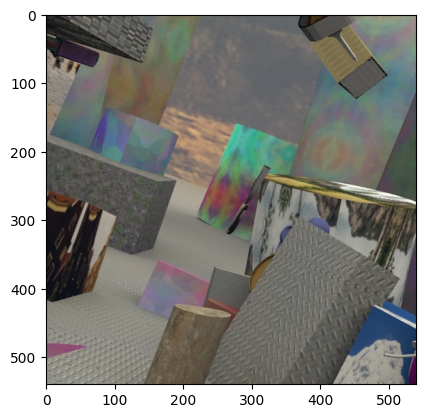

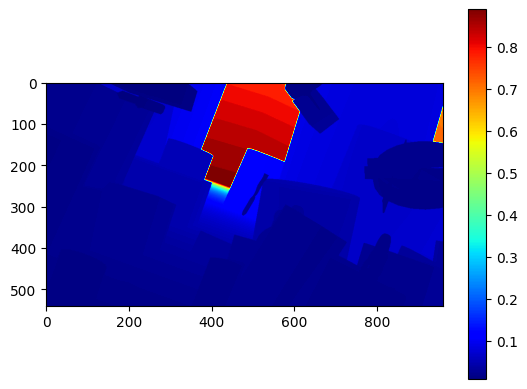

[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


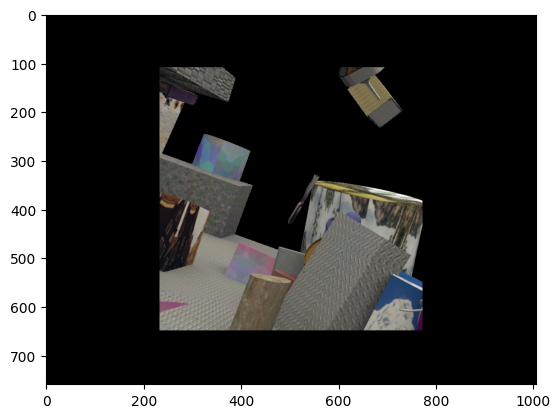

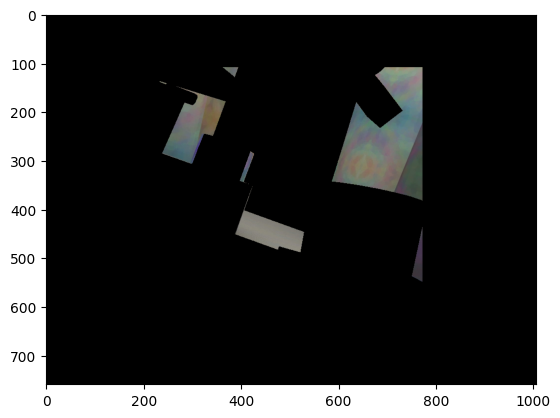

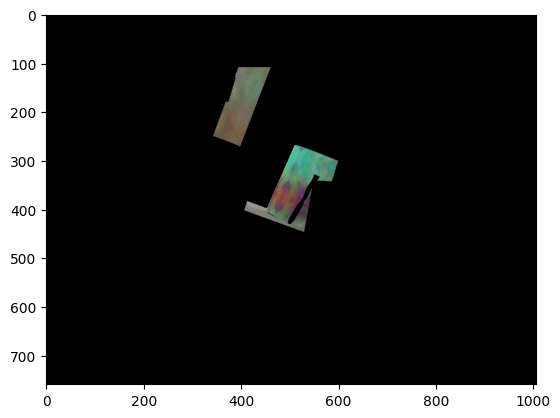

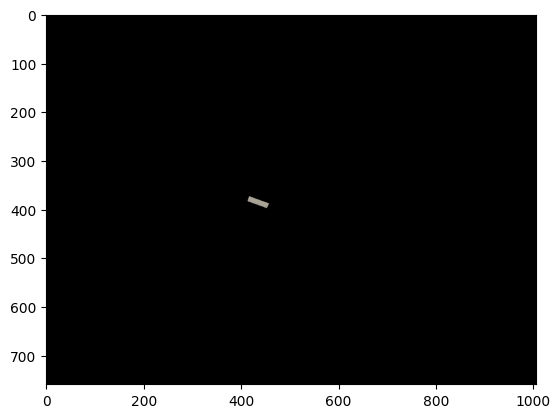

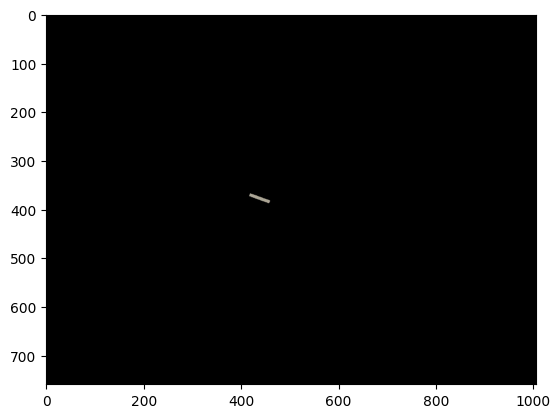

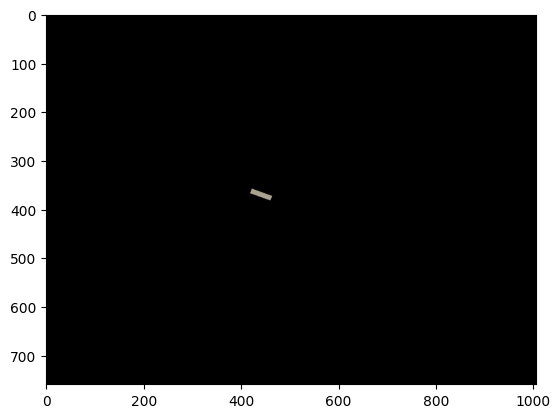

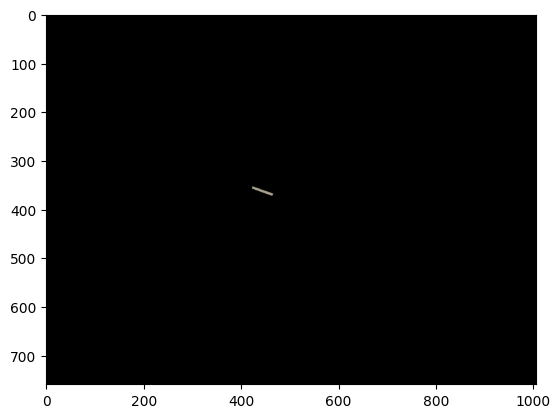

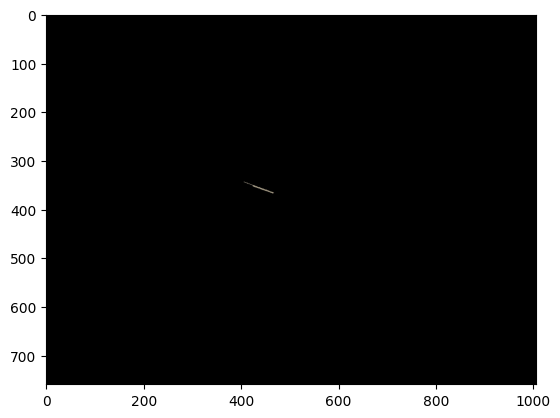

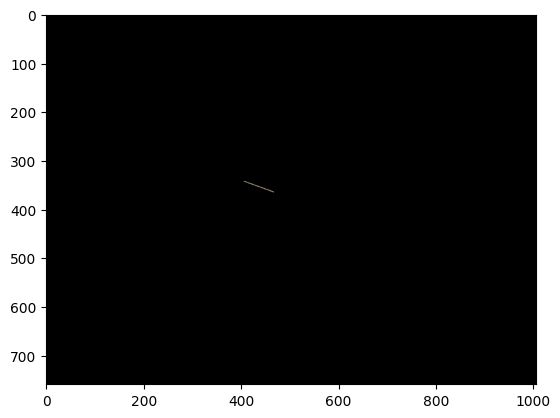

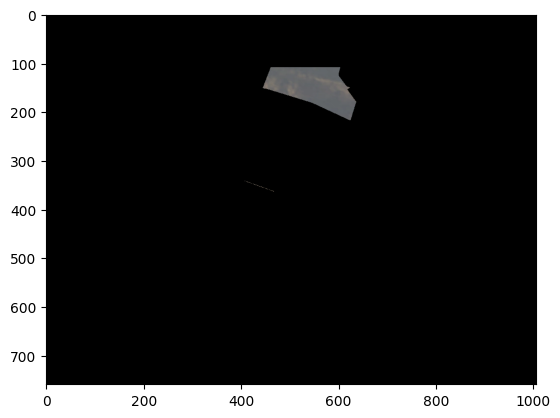

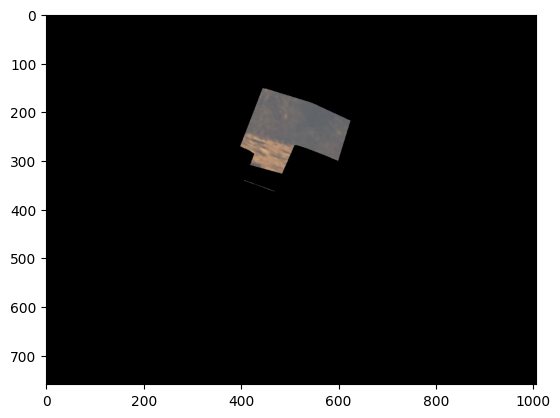

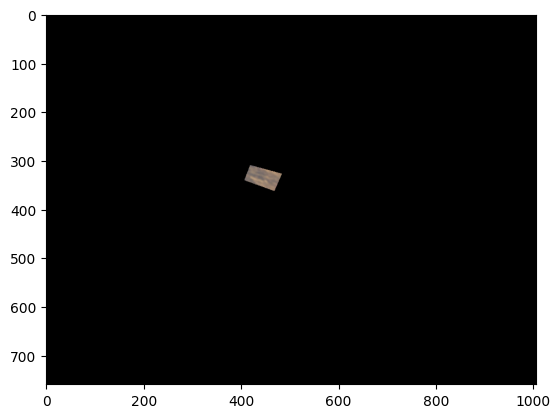

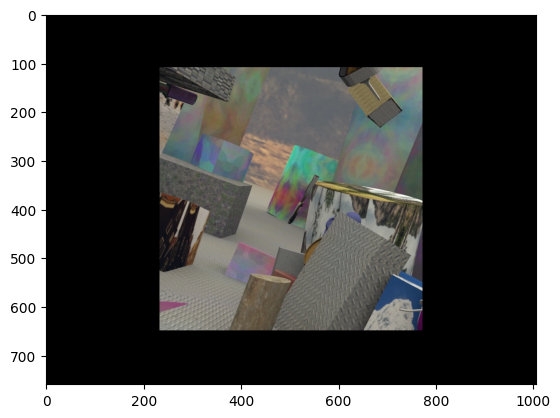

tensor(1., dtype=torch.float64) tensor(255., dtype=torch.float64)
34.700254682049675


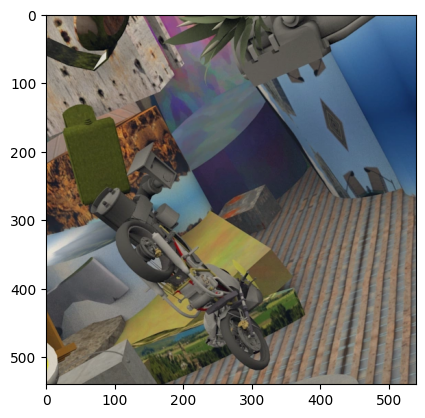

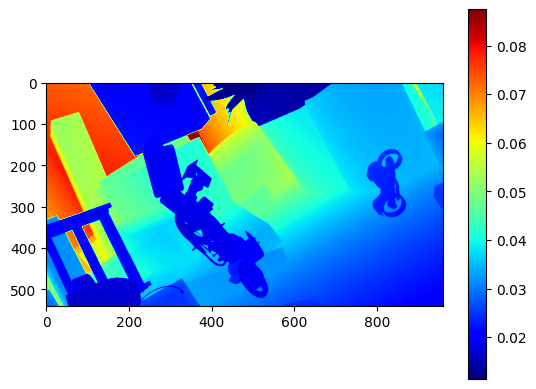

[[3 3 3 ... 6 6 6]
 [3 3 3 ... 6 6 6]
 [3 3 3 ... 6 6 6]
 ...
 [2 2 2 ... 4 4 4]
 [2 2 2 ... 4 4 4]
 [2 2 2 ... 4 4 4]]


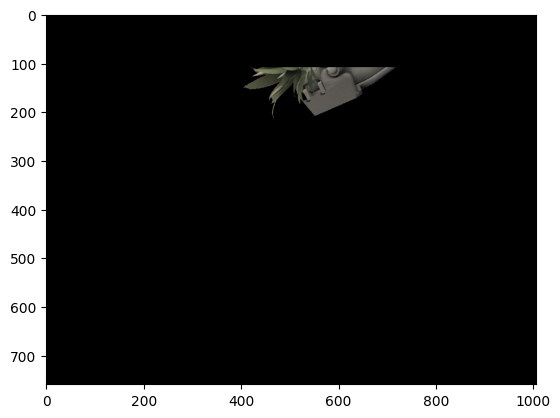

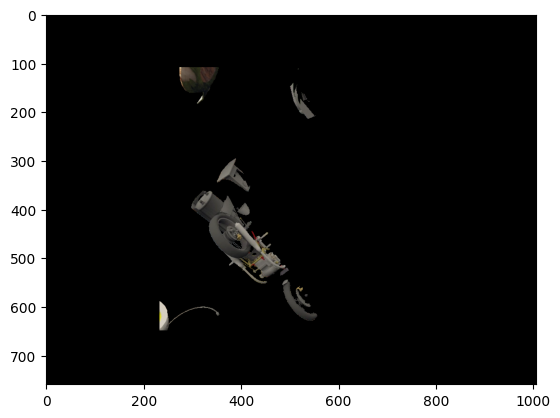

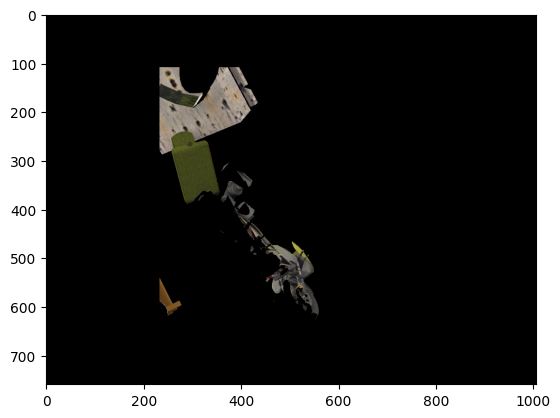

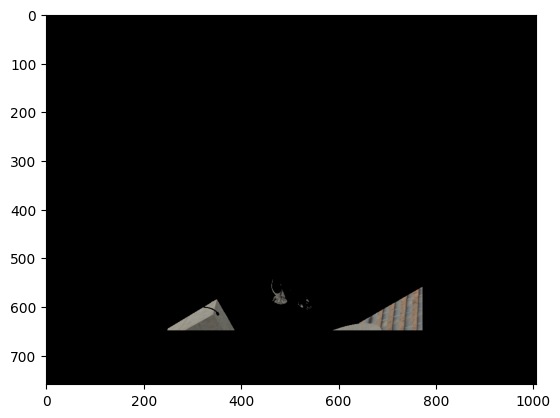

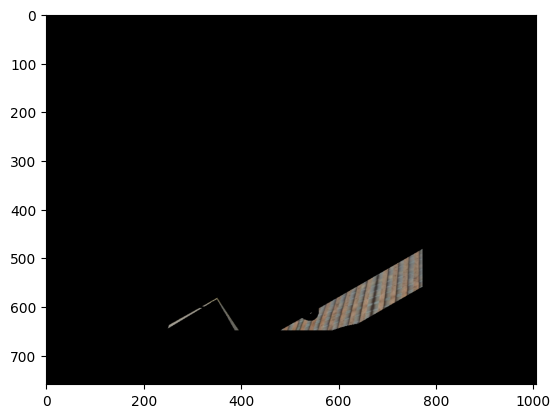

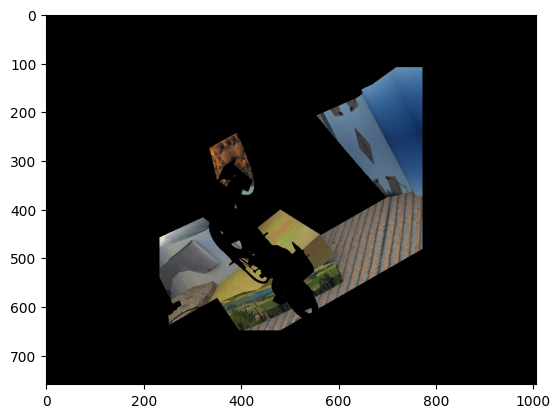

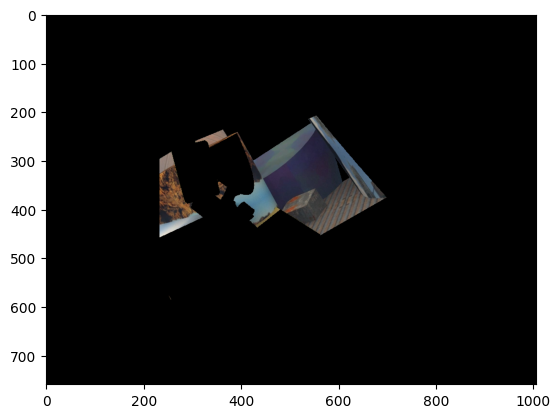

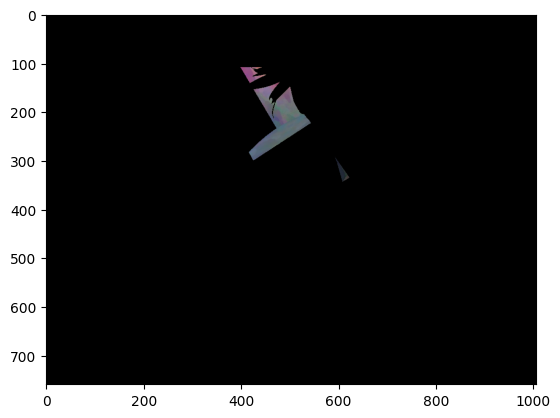

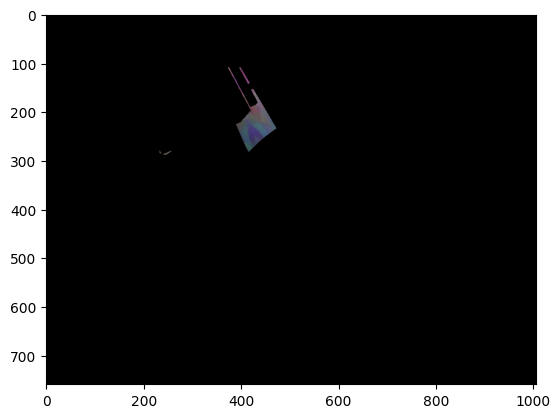

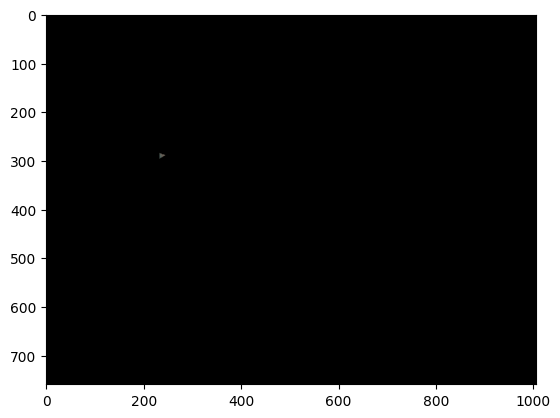

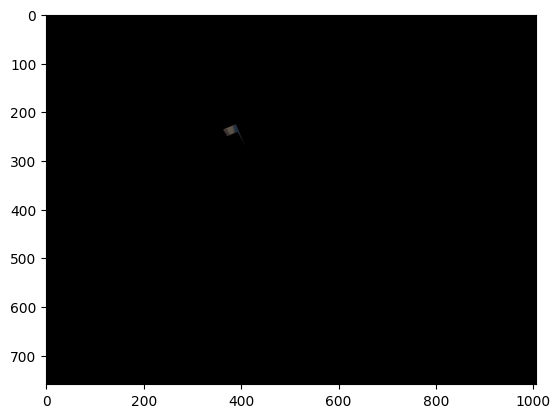

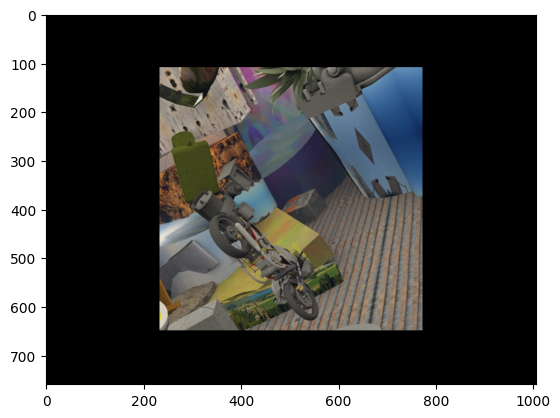

tensor(0.9333, dtype=torch.float64) tensor(255., dtype=torch.float64)
38.681806310277224


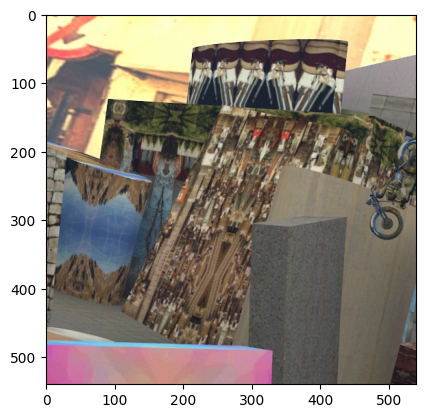

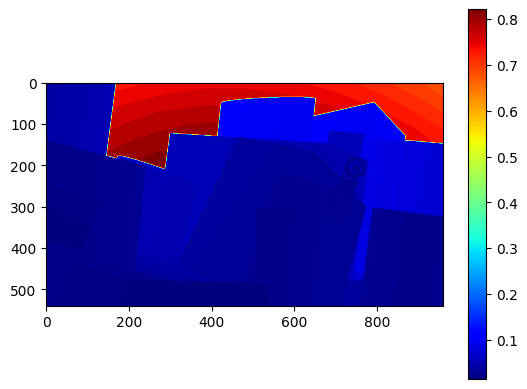

[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]]


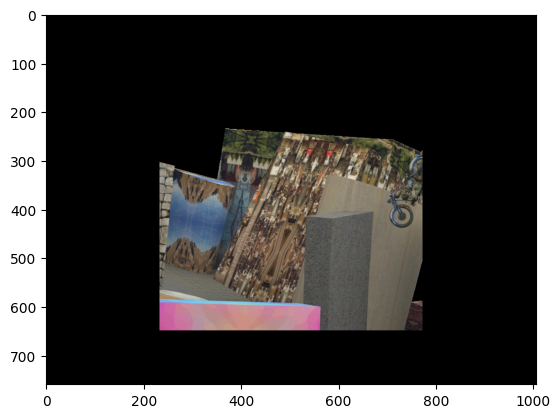

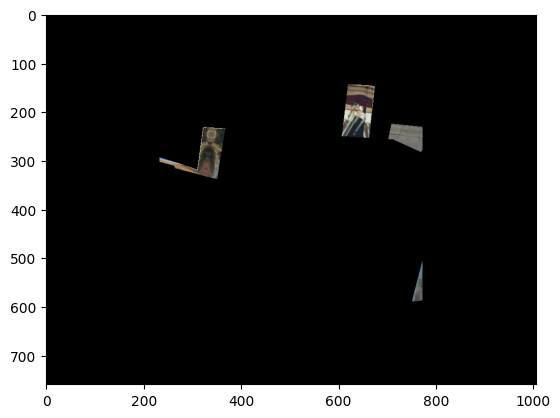

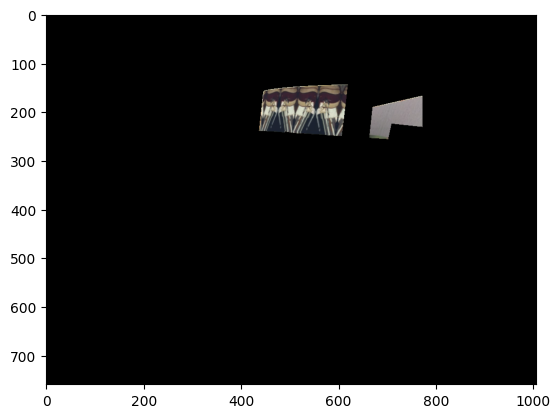

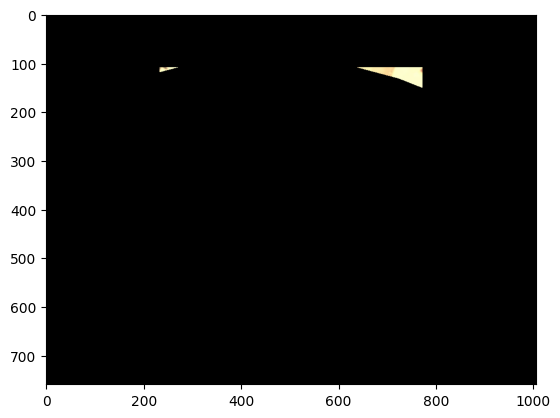

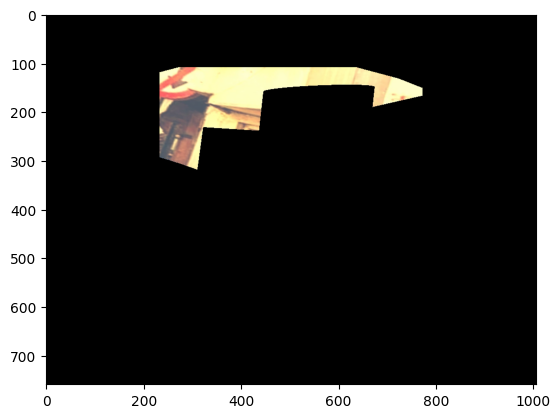

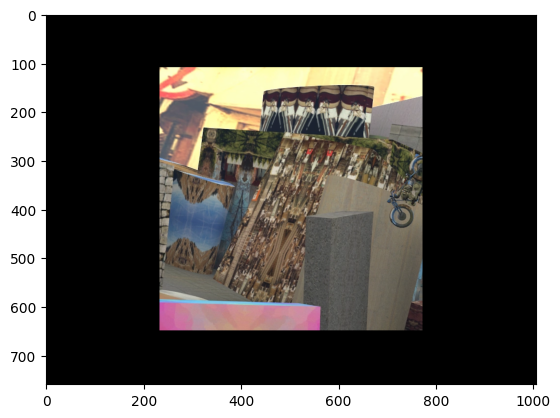

tensor(1., dtype=torch.float64) tensor(255., dtype=torch.float64)
34.432486985389936


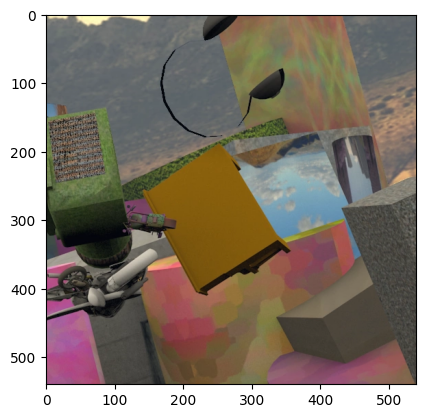

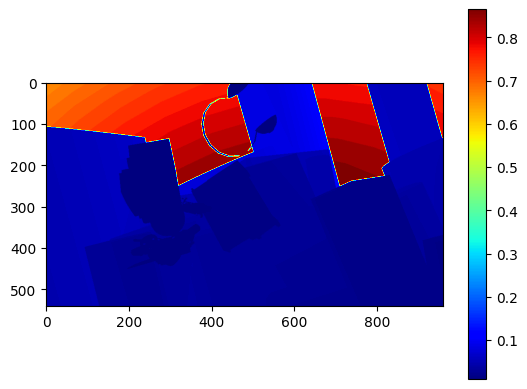

[[ 9  9  9 ... 10 10 10]
 [ 9  9  9 ... 10 10 10]
 [ 9  9  9 ... 10 10 10]
 ...
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]]


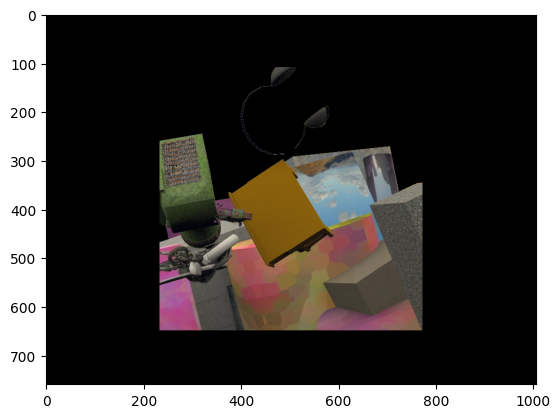

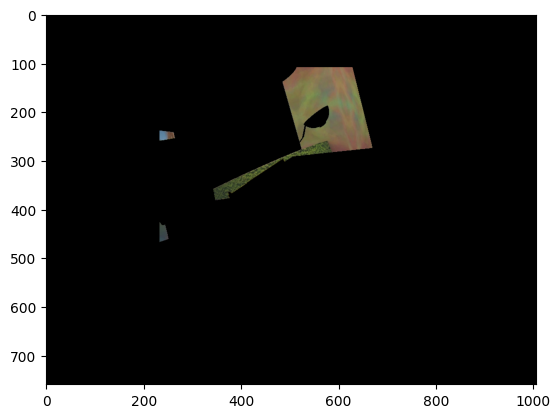

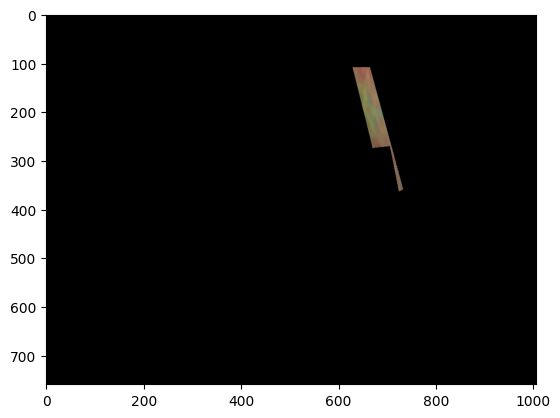

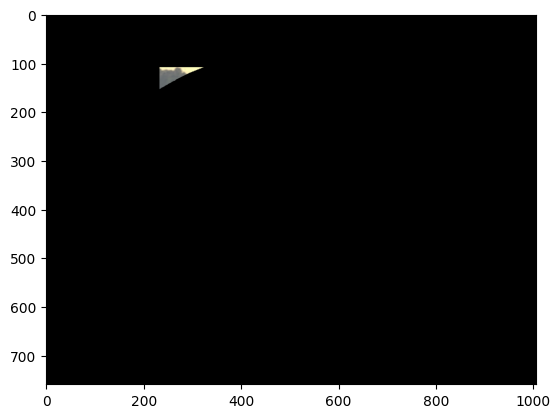

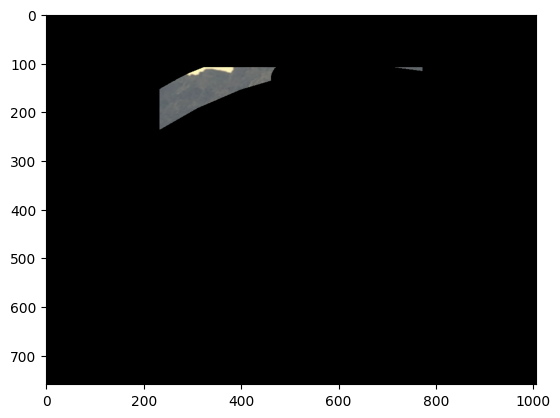

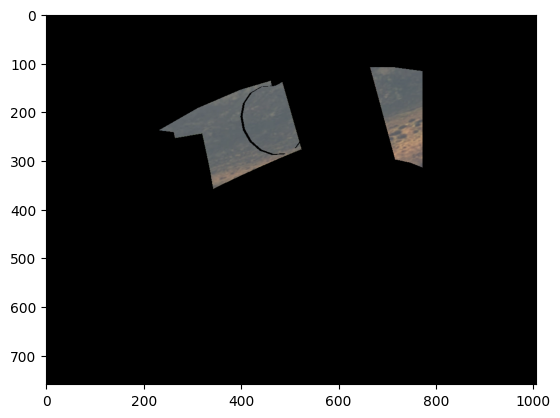

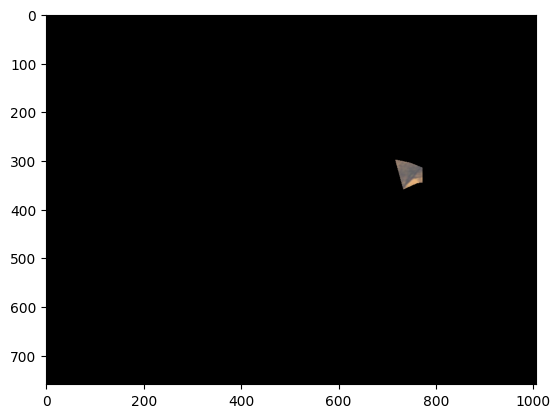

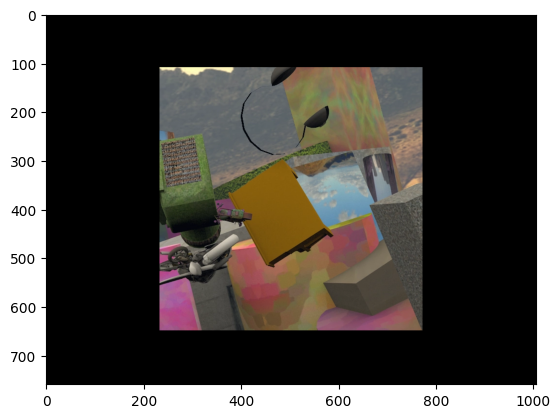

tensor(1., dtype=torch.float64) tensor(255., dtype=torch.float64)
43.9706267531282


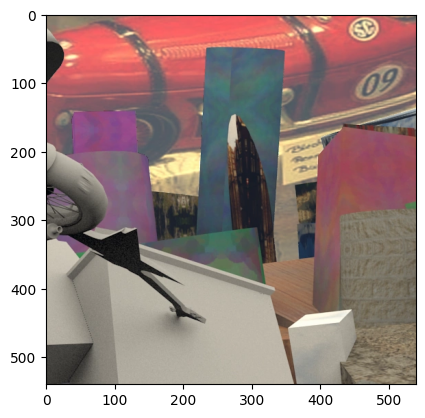

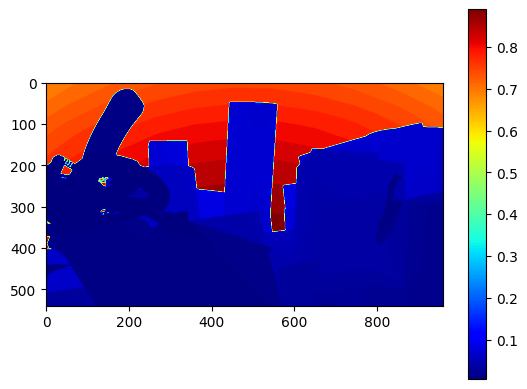

[[9 9 9 ... 9 9 9]
 [9 9 9 ... 9 9 9]
 [9 9 9 ... 9 9 9]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


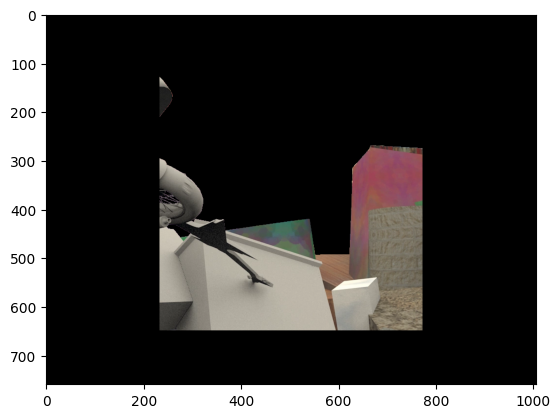

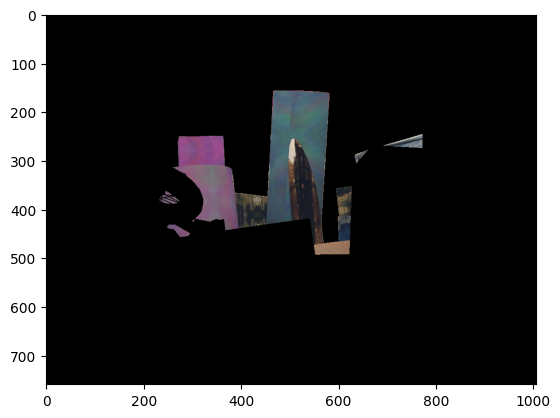

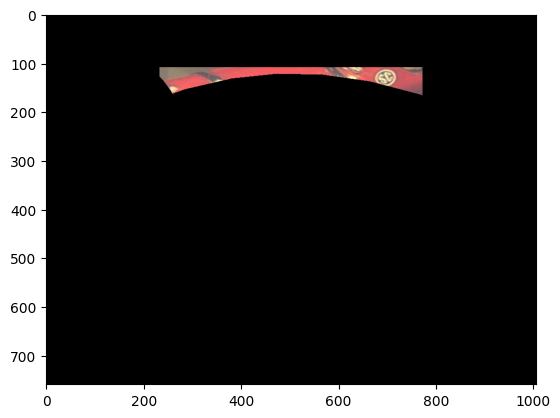

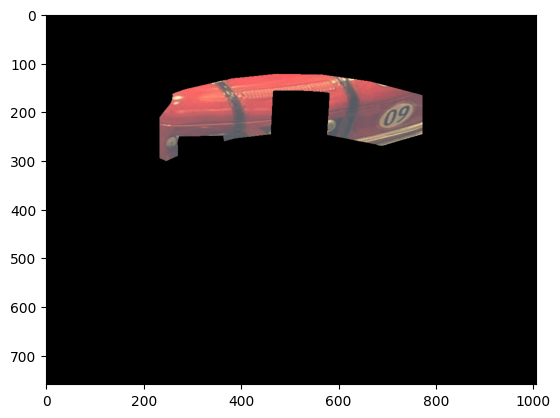

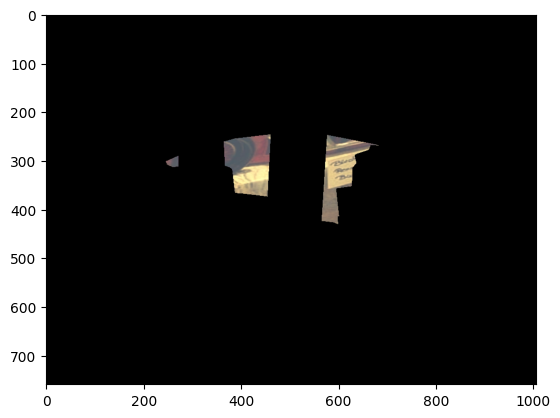

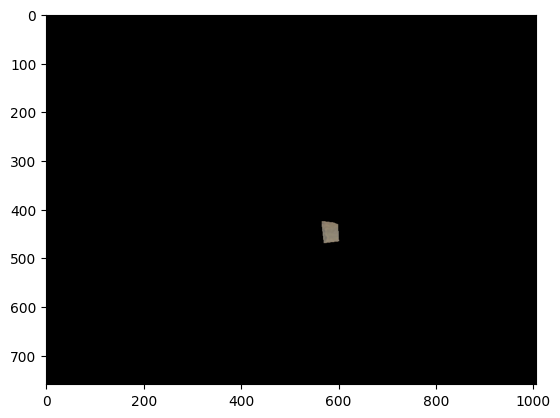

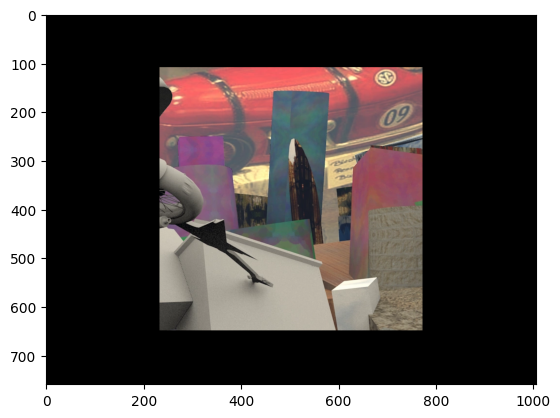

tensor(1., dtype=torch.float64) tensor(255., dtype=torch.float64)
52.1742487165801


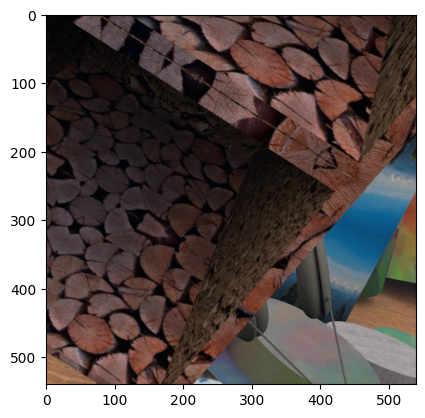

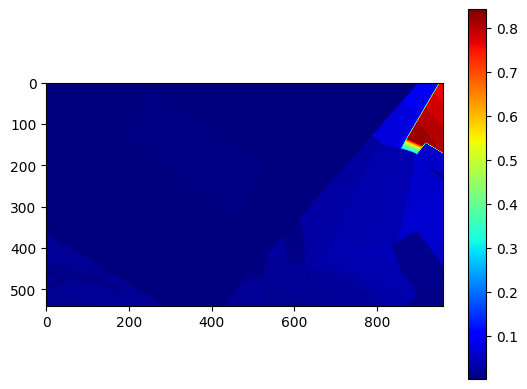

[[2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 ...
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]]


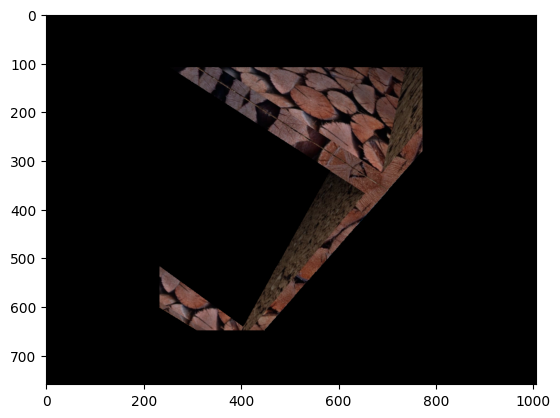

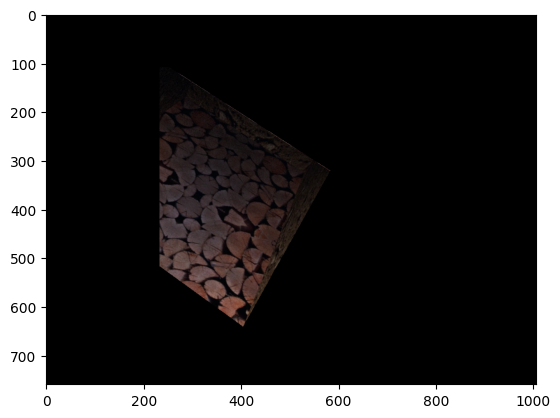

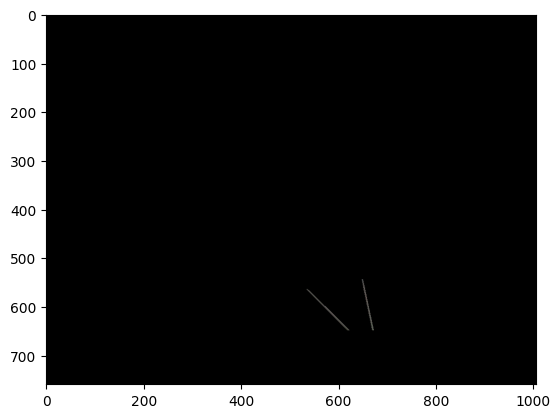

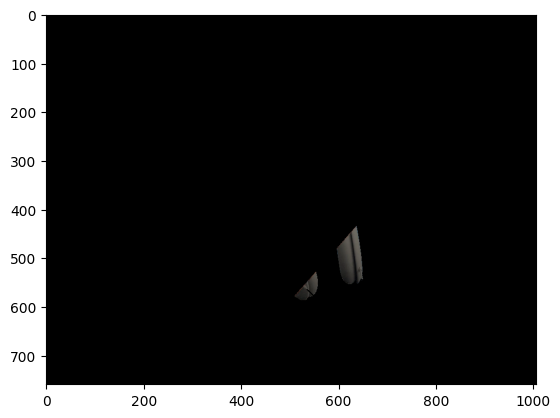

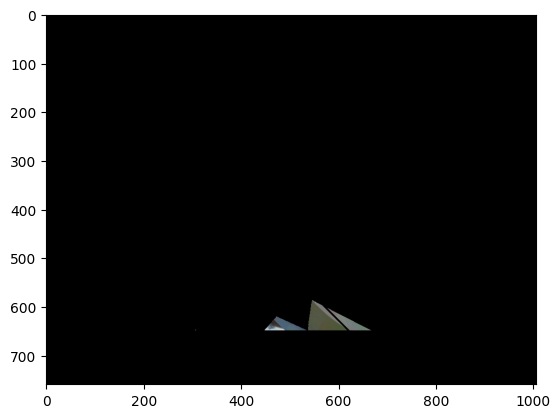

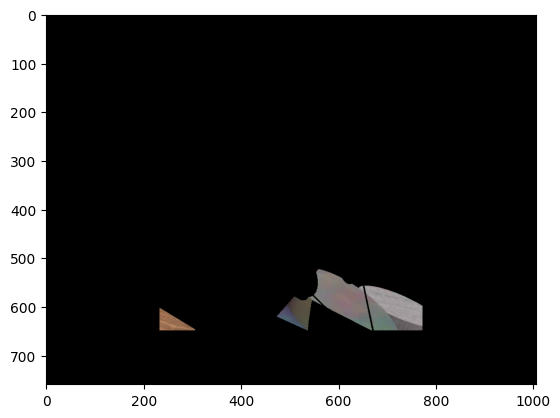

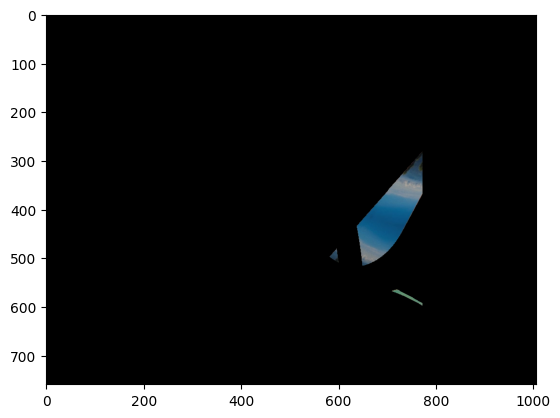

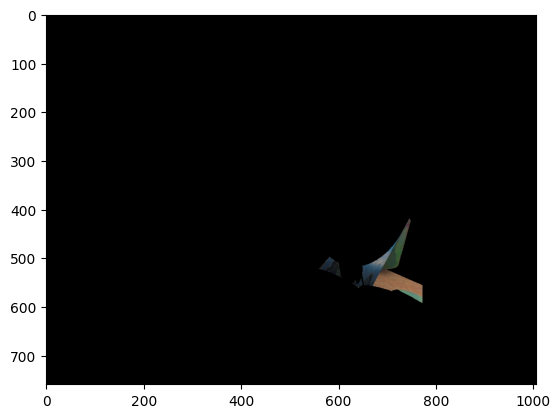

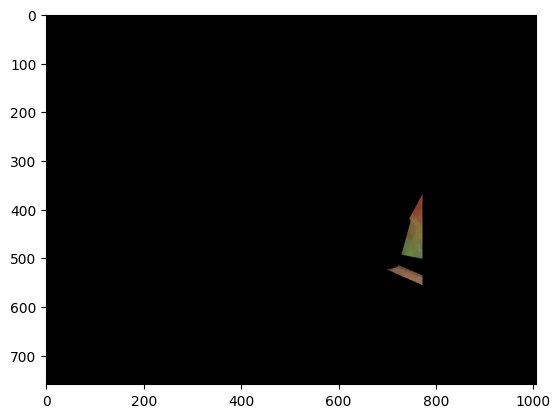

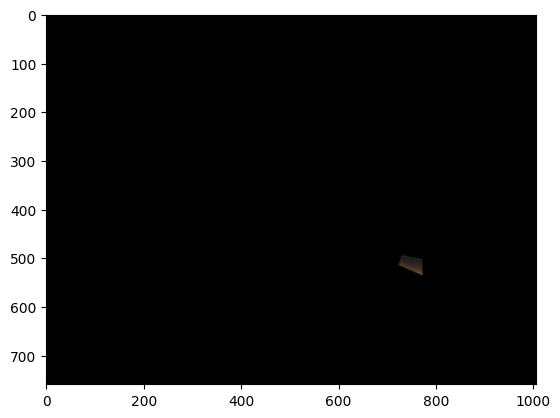

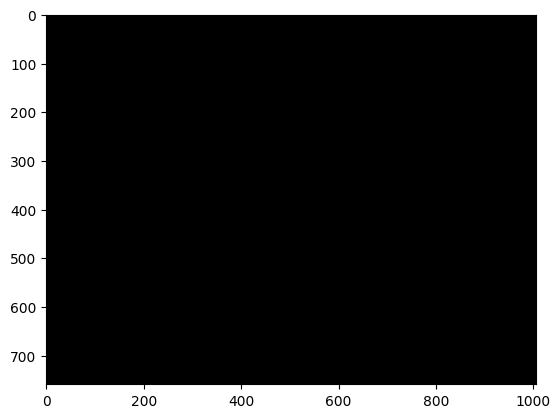

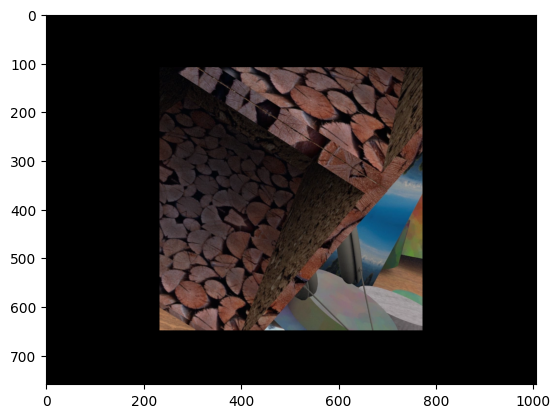

tensor(0.8706, dtype=torch.float64) tensor(255., dtype=torch.float64)
39.82007339057334


KeyboardInterrupt: 

In [3]:
import tqdm
for i ,(meas,im,depth) in enumerate(train_dl):
    #k=meas[0].unsqueeze(0).permute(0,3,1,2)
    print(depth.shape)
    print(meas[0].max(),meas[0].min())
    sample=np.array(meas[0])
    #sample=np.transpose(np.array(sample),(1,2,0))
    captured_image=sample
    plt.imshow((((captured_image-captured_image.min())/(captured_image.max()-captured_image.min()))*255).astype(np.uint8),cmap='gray')
    plt.show()
    
    captured_image=np.transpose(np.array(im[0]),(1,2,0))
    #plt.imshow((((captured_image-captured_image.min())/(captured_image.max()-captured_image.min()))*255).astype(np.uint8))
    #plt.show()

    sample=np.transpose(np.array(sample),(2,0,1))
    #print(sample.shape)
    #c=model(k)
    #print(c.shape)
    
    # Example usage
    original_image = sample  # Your original image with dimensions 3*540*540
    target_psnr = 40  # Target PSNR in dB
    #print(original_image[0].shape)